## Backpropagation

Supervised learning of the weights in a feedforward neural network can be achieved by peforming gradient descent on an error function.  To do so, it is necessary to compute the error gradient with respect to every weight in the network.  In a multi-layer network, the error at the output must be backpropagated through the layers in order to calculate all the required gradients.

I will derive the mathematical expressions that can be used to compute the gradients and then work through an implementation that can be applied to a multi-layer perceptron of any structure, that is any number of layers with any number of neurons in each layer.

### A single neuron

A single neuron has a number of weighted inputs.  The total input, known as the activation, is the sum-product of the input signals and the corresponding weights.  So for $n$ inputs, $x_i$ ($i \in$ 1...$n$), and corresponding weights $ w_i $, 
the activation, $a$, is given by

$$ a = \sum_{i=1}^n w_i x_i $$

The output of the neuron, $y$, is some (usually non-linear) function of the activation:

$$ y = f(a) $$

Training data comprises of a set of $N$ examples, each of which consists of an input pattern, $X_j = (x_1, x_2,...,x_n)_j^T$, and the corresponding target output, $t_j$ ($j \in  1...N$)

For each input pattern, the neuron gives a predicted output, which can be used in conjunction with the target output to quantify the prediction error.

The aim is to find a set of weights that will minimise the total error across all possible input patterns.  However, it is usually not possible to enumerate all the possible input patterns nor to determine the expected output in all cases.  If it were, there would be no need to build a predictive model!  So learning proceeds by finding weights that will minimise the error across all the training examples, rather than across all possible inputs.  In addition, some procedure must be employed to try to ensure that the learned weights will give good predictions when applied to input patterns that were not part of the training set.  In other words, steps must be taken to ensure that training does not lead to overfitting to the training set, so that the network generalises well.  For the time being we will ignore this consideration and just look at how to minimise the training error.

Provided that the functions $f$ and $E_j$ are differentiable, then it is possible to determine the error derivative with respect to each weight and then descend the gradient to find the weights that minimise the error.  The training examples can be batched together to calculate an average gradient or each example can be processed individually and the weights updated for each one.  This is the approach that we will take.  So, if the $j^{th}$ training example is presented at step $t$, all weights will be updated according to:

$$ w_i(t+1) = w_i(t) - \eta \frac{\partial E_j}{\partial w_i} $$

Where $\eta$ is a learning rate.  The derivatives can be computed according to:
$$ \frac{\partial E_j}{\partial w_i} = \frac{dE_j}{dy} \frac{dy}{da} \frac{\partial a}{\partial w_i} $$

In this case, we will use a squared error function: $ E_j = \frac{1}{2} (y - t_j)^2 $, giving
$$ \frac{dE_j}{dy} = y - t_j $$

If we use a sigmoid activation function, $ f(a) = \frac{1}{1 - e^{-a}} $, then:
$$ \frac{dy}{da} = f(a)(1 - f(a)) $$

Finally,
$$ \frac{\partial a}{\partial w_i} = x_i  $$

Yielding 
$$ \frac{\partial E_j}{\partial w_i} = (y - t_j)f(a)(1-f(a))x_i = (y - t_j)y(1 - y)x_i $$



In [1]:
import numpy as np

def single_neuron(inputs, weights):
    # from IPython.core.debugger import Tracer; Tracer()()
    activation = np.dot(weights, inputs)
    output = sigmoid(activation)
    output_gradient = output * (1 - output)
    return (output, output_gradient)
    
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def single_neuron_weight_gradients(inputs, target, output, output_gradient):
    return (output - target) * output_gradient * inputs.T

def update_weights(weights, weight_gradients, learning_rate):
    return weights - learning_rate * weight_gradients

def normalise(vector):
    norm = np.linalg.norm(vector, 2)
    if norm != 0:
        return 100 * vector/np.linalg.norm(vector, 2)
    else:
        return vector

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

def test_data_2_classes(means, covariances, examples_per_class):
    data0 = np.random.multivariate_normal(means[0],covariances[0], examples_per_class)
    data1 = np.random.multivariate_normal(means[1],covariances[1], examples_per_class)
    output0 = [(data, 0) for data in data0]
    output1 = [(data, 1) for data in data1]
    output0.extend(output1)
    return output0

def plot_2d_data_2_classes(data, ax=None):
    
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)        
    
    color_string = ('r', 'b')
    
    for loop_num in (0, 1):
        inputs = [data[n][0] for n in range(len(data)) if data[n][1]==loop_num]
        x1 = [inputs[n][0] for n in range(len(inputs))]
        x2 = [inputs[n][1] for n in range(len(inputs))]
        ax.scatter(x1, x2, color=color_string[loop_num])
    
    return ax

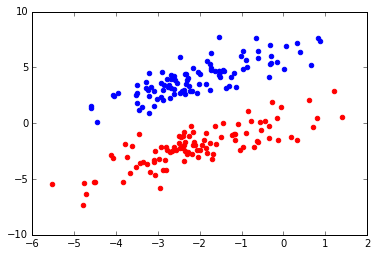

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

means = [(-2,-2), (-2,4)]
covariances = [[[2,2],[2,3]], [[2,2],[2,3]]]
test_data = test_data_2_classes(means, covariances, 100)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax = plot_2d_data_2_classes(test_data, ax)
plt.show()

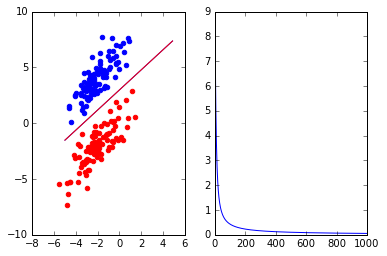

In [4]:
number_of_epochs = 1000
weights = np.array([0.1,0.1,0.1])
# from IPython.core.debugger import Tracer; Tracer()()

total_error_list = []

for epoch in range(number_of_epochs):
    np.random.shuffle(test_data)
    for example in test_data:
        # from IPython.core.debugger import Tracer; Tracer()()
        inputs = np.concatenate((np.array([1]), example[0]))
        # from IPython.core.debugger import Tracer; Tracer()()
        target = example[1]
        (output, output_gradient) = single_neuron(inputs, weights)
        weight_gradients = single_neuron_weight_gradients(inputs, target, output, output_gradient)
        weights = update_weights(weights, weight_gradients, 0.1)        
    # weights = normalise(weights)

    # At the end of each epoch, caculate the error over all training examples
    total_error = 0
    for example in test_data:
        inputs = np.concatenate((np.array([1]), example[0]))        
        target = example[1]
        total_error += (sigmoid(np.dot(weights, inputs)) - target)**2
    total_error_list.append(total_error)
        
# from IPython.core.debugger import Tracer; Tracer()()
normalised_weights = normalise(weights)
x = np.arange(-5,5,0.1)
y = (-weights[1] * x - weights[0])/weights[2]
y2 = (-normalised_weights[1] * x - normalised_weights[0])/normalised_weights[2]
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1 = plot_2d_data_2_classes(test_data, ax1)
ax1.plot(x,y,'b')
ax1.plot(x,y2,'r')
# from IPython.core.debugger import Tracer; Tracer()()
ax2.plot([n + 1 for n in range(len(total_error_list))], total_error_list)
plt.show()

In [5]:
print(weights)
print(np.linalg.norm(weights,2))

[-6.31868961 -2.20988452  2.89090994]
7.29155595483


To test full backprop - estimate error derivatives by bumping activations and observing the effect on the output.